<a href="https://colab.research.google.com/github/Mattobad/Pneumonia-Detection-Deep-Learning/blob/master/End_to_End_Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## End to End image classification for Pneumonia Detection using X-ray Images

#### Introduction

The main motive of starting this project is to build Deep Learning(DL) model to detect presence of pnuemonia provided the patient X-rays images or patient DICOM(Digital Imaging and Communications in Medicine) file. And later on use the trained model to be deployed as web application using docker and flask-python where user can provide X-ray image or DICOM file and see what model predicts. 

In this notebook, we're going to implement end to end Binary image classification(supervised learning) to detect pneumonia in the x-ray images using Tensorflow-keras. We are going to also look into different model architecture(play around with different architecture),  hypermeters optimization.



###### i. Problem
To detect the traces of pneumonia in the x-ray images.

###### ii. Data
The data was taken from Kaggle's Pneumonia detection challenge. [Link to the data](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)

###### iii. Evaluation
Evaluation metric used here is accuracy(how well the model predicted value correspondes with the original value).


**Note:** Model build here is for learning purpose only and not applicable for real case scenario where serious decision is to be made.

Happy Learning!!!

In [ ]:
# process to unzip the file
#!unzip "drive/My Drive/Data/rsna-pneumonia-detection-challenge.zip" -d "drive/My Drive/Data/pneumonia-data"

##### 1. Making your workspace ready.

In [ ]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)

print("TF HUB version:", hub.__version__)
#Check for GPU availability
print("GPU","available (YESS!!)" if tf.config.list_physical_devices("GPU") else "GPU not available")

TF version: 2.2.0
TF HUB version: 0.8.0
GPU available (YESS!!)


In [ ]:
# install the pydicom module as required for patient data
# pypng for converting image pixel into images files(png)
!pip install pydicom pypng

     |████████████████████████████████| 35.5MB 117kB/s 
     |████████████████████████████████| 655kB 46.9MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp36-none-any.whl size=67161 sha256=2b26b64bbbc9d87c7bea6f22db4227f1c6525a8f087a2c9c1007b84504c3f9e9
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom 

labels_csv = pd.read_csv('drive/My Drive/Data/pneumonia-data/stage_2_train_labels.csv')
print(labels_csv.describe())
labels_csv.head(2)

                 x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


In [ ]:
labels_csv[labels_csv['Target'] == 1][:1] 

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


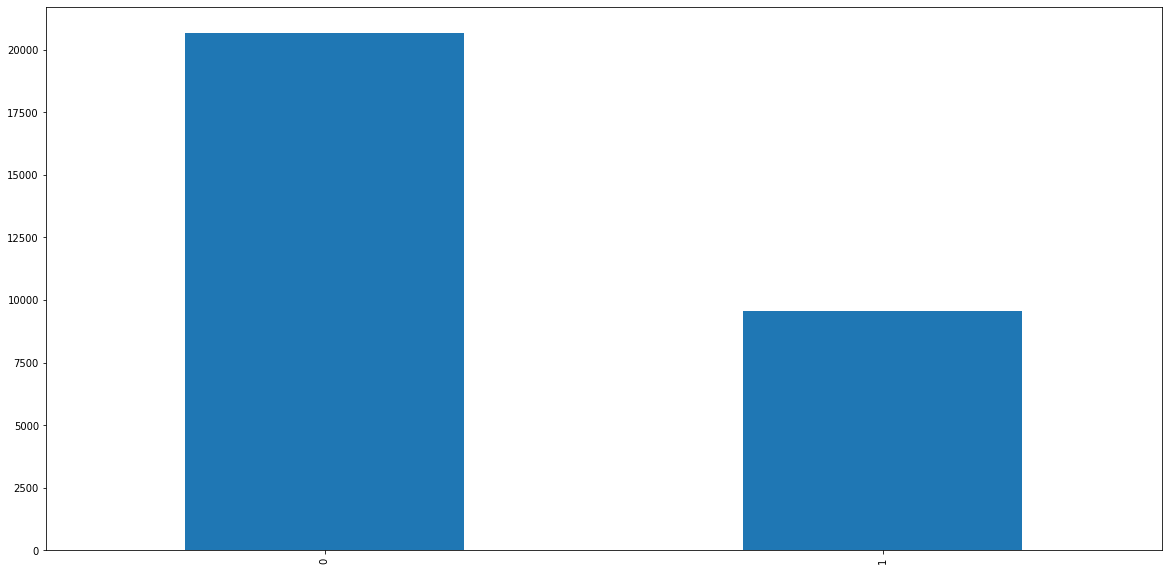

In [ ]:
labels_csv.Target.value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

So,there are 20672 record of patient without pneumonia and 9555 record of patient with pneumonia

##### 2. Understanding the DICOM(Digital Imaging and Communications in Medicine) files

Dicom files consists of all the metadata related to patient including images. Python library pydicom is used here for exploring the dicom files.

In [ ]:
# to read the first patient ID
patientId = labels_csv['patientId'][0]
dcm_file = 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)
#0004cfab-14fd-4e49-80ba-63a80b6bddd6
print()
print(dcm_data["PatientID"])
print()
print()
print()
# check the patient age and sex related specific patient id
print(dcm_data['PatientAge'][:3])
print(dcm_data['PatientSex'][0])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
# function to display images
import pylab
def display_image(img_path):
  """
  Function to display image provided the image path

  Args:
    img_path = path of the image 
  
  Returns:
    None
  """

  im = image_pixel(img_path)
  pylab.imshow(im, cmap=pylab.cm.gist_gray)
  pylab.axis('off')


# function to return image pixel
def image_pixel(file_path):
  """
  Function to extract image pixel from dicom files

  Args:
    file_path: dicom file path
  
  Returns:
    image pixel extracted from dicom file
  """
  dcm_data = pydicom.read_file(file_path)
  img_pixel = dcm_data.pixel_array
  return img_pixel

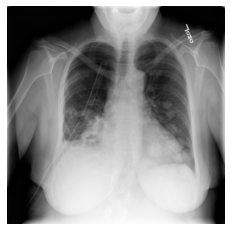

In [ ]:
display_image(dcm_file)

[[255 203 114 ...   9   9   9]
 [233 160  96 ...  12  12  12]
 [180 105  75 ...  12  12  12]
 ...
 [160 167 158 ... 103 104 105]
 [179 166 161 ... 106 104 102]
 [204 170 166 ... 110 110 109]]


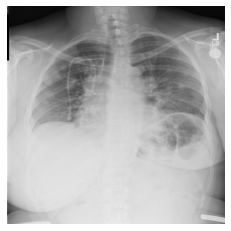

In [ ]:
# testing if the display function for image works
image = image_pixel(filenames[500])
print(image)
display_image(filenames[500])

In [ ]:
# create pathnames from dicom files
filenames = ['drive/My Drive/Data/pneumonia-data/stage_2_train_images/'+fname+'.dcm' for fname in labels_csv['patientId']]
print(len(filenames))
#check the first 10
filenames[:10]

30227


['drive/My Drive/Data/pneumonia-data/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00569f44-917d-4c86-a842-81832af98c30.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/006cec2e-6ce2-4549-bffa-eadfcd1e9970.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
 'drive/My Drive/Data/pneumonia-data/stage_2_train_images/00704310-78a8-4b38-8475-49f4573b2

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('drive/My Drive/Data/pneumonia-data/stage_2_train_images/')) == len(filenames):
  print('Filenames match the actual file length!!')
else:
  print('Filenames doesn\'t match the acutal file length')

print(len(os.listdir('drive/My Drive/Data/pneumonia-data/stage_2_train_images/')),len(filenames))



Filenames doesn't match the acutal file length
26684 30227


In [ ]:
print('Total number of files: {}'.format(len(labels_csv)))
# number of unique patientId
print("Number of unique patient {}".format(len(np.unique(labels_csv['patientId']))))

Total number of files: 30227
Number of unique patient 26684


Number of images doesn't match the number of files of patientID which means all the dicom files of the patient is not in the dataset. There are 26684 train dicom files and 3000 test dicom files which doesn't sum up to 30227(total was 29684 combining both train and test). But while looking for unique patientId found there were only 26684 unique patient. Hence, there were repeated number of patient records.

Now, let's remove the duplicates.

In [ ]:
# new dataFrame without duplicate values
new_df = labels_csv.drop_duplicates('patientId',ignore_index=True)
print('Total number of patient records {}'.format(len(new_df)))
print('Number of unique patient records {}'.format(len(np.unique(new_df['patientId']))))

Total number of patient records 26684
Number of unique patient records 26684


Let's check the number of records of each classes(pneumonia(1) & not pnuemonia(0))

In [ ]:
new_df['Target'].value_counts()

0    20672
1     6012
Name: Target, dtype: int64

There are 20672 number of records without pnuemonia while only 6012 records with pneumonia case. If we take this data and try to create training and validation datasets there will be class imbalance. This will result in baised model due to greater number of pneumonia absent cases in the training data.

Let's make it clear by creating the both datasets

In [ ]:
# lets implement the value_counts of pandas using custom 
# function for any given list
def list_value_counts(l):
  """
  Function returns dict containing the keys as values and values as counts
  for given list

  Args:
    l: given list
  Returns:
    dictionary containing value counts of the list
  """

  # creating empty dictionary
  val_count = dict()
  # looping over the elements of the list
  for item in l:
    if item not in val_count:
      val_count[item] =1
    else:
      val_count[item] +=1

  return val_count



# we are using scikit-learn to divide the train and valid sets
from sklearn.model_selection import train_test_split


# we need shuffled data, so we're using sample from pandas
# using frac=0.3 gives best result for our target classes
#df = combined_df.sample(frac=0.7,random_state=42)

X = new_df.drop('Target',axis=1)
y = new_df['Target']

#print(X.shape,y.shape)

# train:valid (80:20) ratio with shuffle and 
# random state 42(for recreating the event) with 5000 datasets
X_train,X_valid,y_train,y_valid = train_test_split(X,y,
                                                   test_size=0.2,
                                                   random_state=42)

# check classes in each datasets
#print(X_train.shape,X_valid.shape)
print('Training dataset: {}'.format(list_value_counts(y_train)))
print('Validation dataset: {}'.format(list_value_counts(y_valid)))

Training dataset: {0: 16564, 1: 4783}
Validation dataset: {0: 4108, 1: 1229}


As expected, we can see the class imbalance from the above dictionary for both training and validation datasets.

Now, let's try to balance the datasets and then create the train and validation datasets.

In [ ]:
# take equal number of both the classes then split the dataset

# total pnuemonia patient in our dataset
NUM_PNUE = len(new_df[new_df['Target']==1])
# noraml patient with number of pnuemonia data
normal_df = new_df.loc[new_df['Target']==0][:NUM_PNUE]
print('Number of normal patient',normal_df.shape)
#pnuemonia patient
pnuemonia_df = new_df.loc[new_df['Target'] ==1]
print('Number of neumonia patient',pnuemonia_df.shape)
# combine both the dataFrame, default is concat vertically(by index)
combined_df = pd.concat([pnuemonia_df,normal_df],ignore_index=True)

Number of normal patient (6012, 6)
Number of neumonia patient (6012, 6)


In [ ]:
# let's try again to create the datasets after balancing the whole data

X = combined_df.drop('Target',axis=1)
y = combined_df['Target']

#print(X.shape,y.shape)

# train:valid (80:20) ratio with shuffle and 
# random state 42(for recreating the event) with 5000 datasets
X_train,X_valid,y_train,y_valid = train_test_split(X,y,
                                                   test_size=0.2,
                                                   random_state=42)

# check classes in each datasets
#print(X_train.shape,X_valid.shape)
print('Training dataset: {}'.format(list_value_counts(y_train)))
print('Validation dataset: {}'.format(list_value_counts(y_valid)))

Training dataset: {1: 4806, 0: 4813}
Validation dataset: {1: 1206, 0: 1199}


From above, we saw there was a close to balance datasets, consisting only 7 more data in normal than in pneumonia case for both the datasets.

###### Extracting images and metadata related to patient from the dicom files

Here, we're extracting images and metadata( Age, Sex for analysis of different age group and sex) from patient dicom files using custom methods. 

Note: For more details on the custom methods check the dicomutils.py file.

In [ ]:
train_files = [x for x in X_train['patientId']]
valid_files = [x for x in X_valid['patientId']]
len(train_files),len(valid_files)

(9619, 2405)

In [ ]:
# calling custom class Dicomutils for extraction
from dicomutils import Dicomutils

base_path = os.getcwd()
src_path = os.path.join(base_path,'stage_2_train_images')

des_path = base_path

d = Dicomutils(src_path,des_path)

In [ ]:
# converts the images placing into train and valid folder accordingly as well as
# outputs csv file containing the metadata for each patient
d.extract_patient_data(train_files,valid_files)

In [ ]:
# reading the newly created csv file
meta_df = pd.read_csv('drive/My Drive/Data/pneumonia-data/patient_records.csv')
meta_df.head()

,Patient_Id,Age,Sex
0,b70a7d7e-3e11-4a74-998f-67eabfa438df,37,M
1,274f1a78-5887-4694-8fd6-a1847d9bc486,36,F
2,62829608-8d5e-4159-bcc6-366960fd1949,49,F
3,b6276787-bf66-4151-9f7a-b3d7fdf5ae30,33,M
4,8810a730-3f76-408d-ac9d-cef6e9629c89,42,M


In [ ]:
# merge combined_df and new_df
temp_df = combined_df.merge(meta_df,on='patientId',how='inner')

In [ ]:
temp_df.to_csv('patient_final.csv',index=False)

In [ ]:
# reading the newly created dataFrame
final_df = pd.read_csv('drive/My Drive/Data/pneumonia-data/patient_final.csv')
final_df.head()

,patientId,x,y,width,height,Target,age,sex
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,32,F
1,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,75,M
2,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,6,F
3,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,23,F
4,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1,58,M


###### Section for EDA(Exploratory Data Analysis)

Let's analysis the data.

In [ ]:
group_gender = final_df.groupby(['Target','sex'])['sex'].size()
group_gender

Target  sex
0       F      2619
        M      3393
1       F      2502
        M      3510
Name: sex, dtype: int64

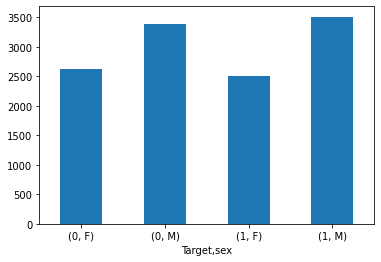

In [ ]:
group_gender.plot.bar()
plt.xticks(rotation=0)
plt.show()

From the graph, we can see that there are more records of male compared to female.

In [ ]:
for index,item in group_gender.items():
  print(index,item)

(0, 'F') 2619
(0, 'M') 3393
(1, 'F') 2502
(1, 'M') 3510


In [ ]:
ratio_female = group_gender[0][0] /group_gender[1][0]
print('Female normal to pneumonia case ratio = {}'.format(ratio_female))
ratio_male = group_gender[0][1] /group_gender[1][1]
print('Male normal to pneumonia case ratio = {}'.format(ratio_male))

Female normal to pneumonia case ratio = 1.0467625899280575
Male normal to pneumonia case ratio = 0.9666666666666667


Here, normal to pneumonia case ratio is higher for male compared to female. This signifies that pneumonia case for male are comparatively high as number of pneumonia cases are higher in male than in female according to given data.

Let's explore the data for understanding effects pneumonia on different age group.

In [ ]:
final_df['age'].describe()

count    12024.000000
mean        46.659348
std         16.982587
min          1.000000
25%         34.000000
50%         49.000000
75%         59.000000
max        148.000000
Name: age, dtype: float64

Max age is 148 which is obvious outlier(as oldest person ever lived was of age 122 according to Guinessworldrecords). 

Let's remove the outliers

In [ ]:
final_df[final_df['age'] >100]

,patientId,x,y,width,height,Target,age,sex
8056,3b8b8777-a1f6-4384-872a-28b95f59bf0d,NaN,NaN,NaN,NaN,0,148,M


In [ ]:
# removing the only one outlier age 148
patient_df =final_df[final_df['age'] <=100]

In [ ]:
type(patient_df['age'].values[0])

numpy.int64

In [ ]:
def age_category(age):
  """
  Function that introduces age category in the dataFrame

  Args:
    df: dataFrame

  Returns:
    df: updated dataFrame with age category"""

  if age <=12:
    return 'child'
  elif age> 12 and age < 19:
    return 'adolescence'
  elif age>18 and age <60:
    return 'adult'
  else:
    return 'senior adult'

In [ ]:
import warnings
warnings.filterwarnings('ignore')
patient_df['age_category'] = patient_df['age'].apply(lambda val: age_category(val))

In [ ]:
patient_df['age_category'].value_counts()

adult           8428
senior adult    2879
adolescence      423
child            293
Name: age_category, dtype: int64

In [ ]:
patient_df.sample(5)

,patientId,x,y,width,height,Target,age,sex,age_category
11955,64739b6b-2ef7-459e-8604-0578392094bd,NaN,NaN,NaN,NaN,0,11,F,child
5206,e65d66fe-2835-4e27-859b-a65065758cab,555.0,243.0,209.0,365.0,1,58,M,adult
9430,4b0f3bf3-fa7c-4e6d-9ef9-2d65f485021c,NaN,NaN,NaN,NaN,0,14,F,adolescence
5952,2ce34f96-40b4-4d2a-b6a1-c7e21e6db8a1,269.0,493.0,218.0,318.0,1,59,M,adult
10291,5382542a-4669-4044-bd7a-9ff2dad7db6b,NaN,NaN,NaN,NaN,0,17,F,adolescence


In [ ]:
import seaborn as sns

# gorup the values by target

group_target = patient_df.groupby(['Target','sex','age_category']).size()
group_target

Target  sex  age_category
0       F    adolescence       66
             adult           1877
             child             53
             senior adult     623
        M    adolescence      115
             adult           2314
             child             55
             senior adult     908
1       F    adolescence       87
             adult           1779
             child             86
             senior adult     550
        M    adolescence      155
             adult           2458
             child             99
             senior adult     798
dtype: int64

In [ ]:
group_age_cat = patient_df.groupby(['Target','age_category']).size()
group_age_cat

Target  age_category
0       adolescence      181
        adult           4191
        child            108
        senior adult    1531
1       adolescence      242
        adult           4237
        child            185
        senior adult    1348
dtype: int64

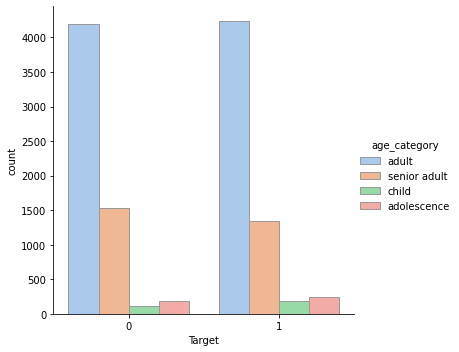

In [ ]:
sns.catplot(x='Target',hue='age_category',kind='count',
            palette='pastel',edgecolor='0.6',data=patient_df)

plt.show()

Even though there are more data of adults and senior adults compared to other age categories, you can see form the data that ratio of pneumonia to normal was highest child(1.71). This is followed by adolescence(1.34), adult(1.01) and senior adult(0.88)

Note: This analysis can't be applied to conclude that certain age groups are more effected than other. Because we can't confirm that for sure this sample data represents the intended population.

In [ ]:
bool_test = (patient_df['sex'] == 'F')  & (patient_df['Target']==1) &(patient_df['age_category']=='adult')

len(patient_df.loc[bool_test,['age_category','Target','sex']])

1779

In [ ]:
bool_female_p = (patient_df['sex'] == 'F')  & (patient_df['Target']==1)
bool_female_n = (patient_df['sex'] == 'F')  & (patient_df['Target']==0)
bool_male_p = (patient_df['sex'] == 'M')  & (patient_df['Target']==1)
bool_male_n = (patient_df['sex'] == 'M')  & (patient_df['Target']==0)

female_p =patient_df.loc[bool_female_p,['age_category','Target','sex']]
female_n =patient_df.loc[bool_female_n,['age_category','Target','sex']]
male_p =patient_df.loc[bool_male_p,['age_category','Target','sex']]
male_n =patient_df.loc[bool_male_n,['age_category','Target','sex']]

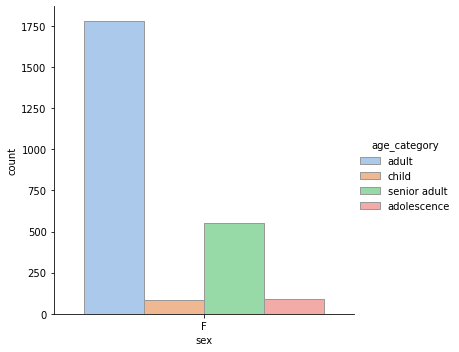

In [ ]:
sns.catplot(x='sex',hue='age_category',kind='count',
            palette='pastel',edgecolor='0.6',data=female_p)

plt.show()

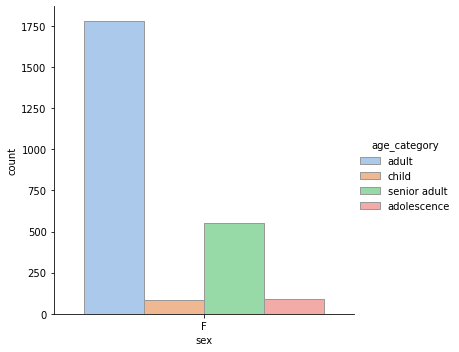

In [ ]:
sns.catplot(x='sex',hue='age_category',kind='count',
            palette='pastel',edgecolor='0.6',data=female_p)

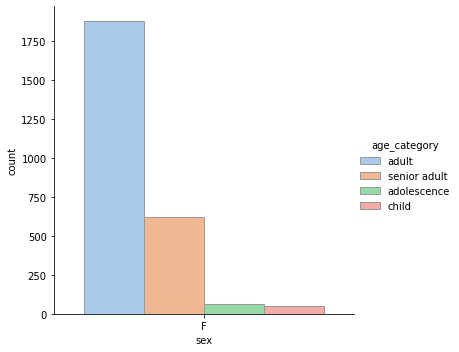

In [ ]:
sns.catplot(x='sex',hue='age_category',kind='count',
            palette='pastel',edgecolor='0.6',data=female_n)

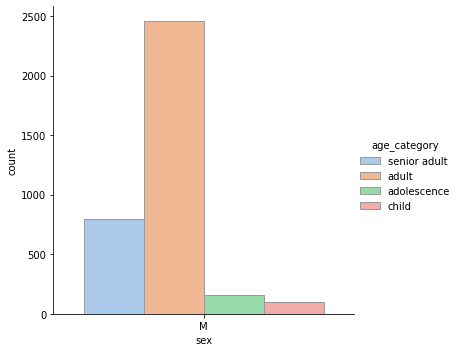

In [ ]:
sns.catplot(x='sex',hue='age_category',kind='count',
            palette='pastel',edgecolor='0.6',data=male_p)

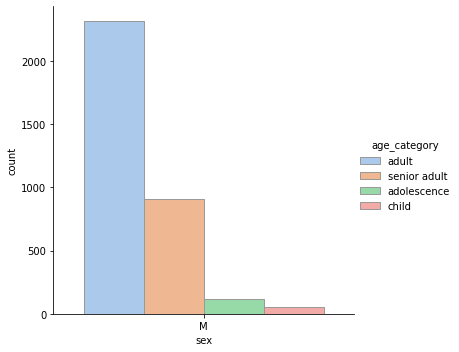

In [ ]:
sns.catplot(x='sex',hue='age_category',kind='count',
            palette='pastel',edgecolor='0.6',data=male_n)

##### 3. Turning images into Tensor
Here we import standard libraries to convert the images to tensor, for making data ready to be feed into the Neural Network.

We're using ImageGenerator from keras for this purpose.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


# challenges:-
#1. need both training as well as validation directory
# ->Problem: all the data are in same directory
# ->solution: separate the files and move to new respective directory..

# function to instantiate two image generator

def image_generator(train_dir,valid_dir):
  """
  
  """
  # instantiate two image generator classes:
  #train data with data agumentation applied
  train_datagen = ImageDataGenerator(
    rescale =1.0/255,
    #data_format='channels_last',
    rotation_range =30,
    horizontal_flip = True,
    fill_mode = 'reflect'
  )
  # no data agumentationas validation data doesn't require it
  valid_datagen = ImageDataGenerator(
    rescale=1.0/255,
    #data_format='channels_last'      
    )

  # define the batch size:
  batch_size =32

  #define the train and validation data generators:
  train_generator = train_datagen.flow_from_directory(
      directory = train_dir,
      target_size =(64,64), # to resize all images with same shape
      class_mode ='binary',
      batch_size =batch_size,
      shuffle=True,
      seed = 42
  )

  # valid gen
  valid_generator = valid_datagen.flow_from_directory(
      directory = valid_dir,
      target_size = (64,64),
      class_mode = 'binary',
      batch_size =batch_size,
      shuffle = True,
      seed =42
  )

  return train_generator,valid_generator

Now, we can call the Image generator function we define earlier to process the images.

In [ ]:
import os
# common path(main)
path = "drive/My Drive/Data/pneumonia-data"
# source path
s_path =os.path.join(path,"stage_2_train_images")
# destination path
des_path =os.path.join(path,"train")

com_path = des_path
print(com_path)
print(path)

drive/My Drive/Data/pneumonia-data/train
drive/My Drive/Data/pneumonia-data


In [ ]:
# train and valid directory path
train_path = os.path.join(com_path,"train")
valid_path = os.path.join(com_path,"valid")

# calling the image generator function
train_gen, valid_gen = image_generator(train_path,valid_path)

**Problem here is ImageGenerator expect images of different class into different folders...**

- create normal and pnuemonia folder
- put the appropriate file into these folders

Note: Before doing above task, we also have to seperate both training and validation set. After that, we can perform the task of class seperation. Another thing is we can also train the model without moving files into their respective class folder(this process can be found on the dog-breed classification notebook). But as we're trying use Keras ImageGenerator following process is required(moving files to their respective class folder). 


So, in next few cells, we are going to automate the moving process using python os module.

In [ ]:
#list containig the target classes
classes = np.unique(y_train)
# for train data
d.class_folder(final_df,train_path,classes)
# for valid data
d.class_folder(final_df,valid_path,classes)

In [ ]:
# calling the image generator function
train_gen, valid_gen = image_generator(train_path,valid_path)

Found 3817 images belonging to 2 classes.
Found 916 images belonging to 2 classes.


##### Building model (inspired by leNet-5 archtecture)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Flatten 


n_classes =2

model = Sequential()

# first convolutional layer:
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',
                input_shape=(64,64,3)))

# second conv layer, with pooling and dropout:
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

# dense hidden layer, with dropout:
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

# output layer:
# using unit=1 as output in binary
model.add(Dense(units=1,activation='softmax'))
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               7372928   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

We, have to resize the image before feed into NN cause its to large to fit in memory....

In [ ]:
history = model.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
120/120 [==============================] - 63s 524ms/step - loss: 8.0008 - accuracy: 0.4771 - val_loss: 6.0997 - val_accuracy: 0.4585
Epoch 2/25
120/120 [==============================] - 57s 473ms/step - loss: 8.0110 - accuracy: 0.4771 - val_loss: 7.6246 - val_accuracy: 0.4585
Epoch 3/25
120/120 [==============================] - 57s 475ms/step - loss: 8.0211 - accuracy: 0.4771 - val_loss: 6.8622 - val_accuracy: 0.4585
Epoch 4/25
120/120 [==============================] - 56s 463ms/step - loss: 8.0110 - accuracy: 0.4771 - val_loss: 6.8622 - val_accuracy: 0.4585
Epoch 5/25
120/120 [==============================] - 56s 464ms/step - loss: 7.9907 - accuracy: 0.4771 - val_loss: 7.6246 - val_accuracy: 0.4585
Epoch 6/25
120/120 [==============================] - 56s 464ms/step - loss: 8.0211 - accuracy: 0.4771 - val_loss: 9.9120 - val_accuracy: 0.4585
Epoch 7/25
120/120 [==============================] - 55s 461ms/step - loss: 8.0110 - accuracy: 0.4771 - val_loss: 7.6246 - val_ac

In [ ]:
import matplotlib.pyplot as plt
# function to plot the graph for trained model

def graph_trained_model(history,epochs):
  """
  Function to show to graph of the trained model for evaluation

  Args:
    history: dictionary containing model performace history
    epochs: number of iteration the model is trained on

  Returns:
    None
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

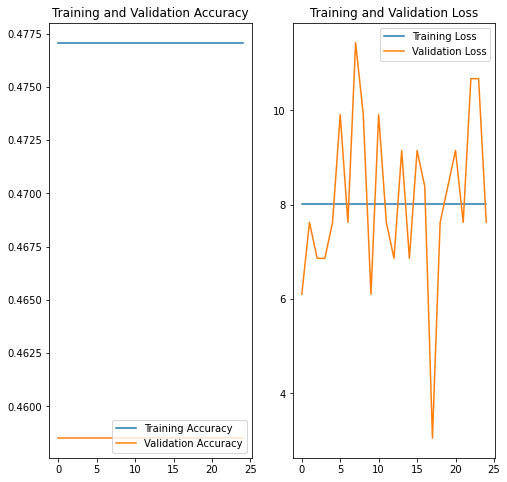

In [ ]:
graph_trained_model(history,25)

The model inspired by LeNet architecture didn't perform well. As we can see the model was not able to learn from the graph(Straight line). So, we are to experiement with different architecture(modified the mode architecture) for model improvement.

#### Trying out another model architecture 

In [ ]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

Using TensorFlow backend.


In [ ]:
def model_create():
    model = Sequential()
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(units=128,activation='relu'))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model = model_create()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history1 = model.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
120/120 [==============================] - 62s 513ms/step - loss: 0.7331 - accuracy: 0.6453 - val_loss: 0.8837 - val_accuracy: 0.6910
Epoch 2/25
120/120 [==============================] - 56s 469ms/step - loss: 0.5542 - accuracy: 0.7286 - val_loss: 0.6904 - val_accuracy: 0.7271
Epoch 3/25
120/120 [==============================] - 56s 467ms/step - loss: 0.5534 - accuracy: 0.7218 - val_loss: 0.7759 - val_accuracy: 0.7205
Epoch 4/25
120/120 [==============================] - 56s 464ms/step - loss: 0.5468 - accuracy: 0.7286 - val_loss: 0.5137 - val_accuracy: 0.7293
Epoch 5/25
120/120 [==============================] - 56s 470ms/step - loss: 0.5411 - accuracy: 0.7312 - val_loss: 0.7760 - val_accuracy: 0.7140
Epoch 6/25
120/120 [==============================] - 55s 460ms/step - loss: 0.5436 - accuracy: 0.7291 - val_loss: 0.6226 - val_accuracy: 0.6932
Epoch 7/25
120/120 [==============================] - 55s 462ms/step - loss: 0.5302 - accuracy: 0.7417 - val_loss: 0.7406 - val_ac

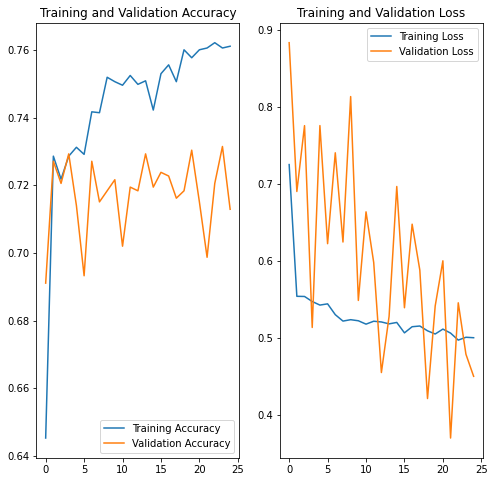

In [ ]:
graph_trained_model(history1,25)

Graph shows there is gradual increase in the training accuracy but validaton loss is consistency. These is the case of neuron saturation or in other sense overfitting.

Note: Learning is very slow need to set the learning parameter inoder to check if any improvements can be done.

##### Trying our third model with added second layer in the second model

In [ ]:
def model_create1():
    model = Sequential()
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.25))

    # second layer
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=128,activation='relu'))
    # adding dropout
    model.add(Dropout(0.5))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model1 = model_create1()
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)             

In [ ]:
history2 = model1.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
120/120 [==============================] - 64s 532ms/step - loss: 0.6357 - accuracy: 0.6269 - val_loss: 0.5610 - val_accuracy: 0.6779
Epoch 2/25
120/120 [==============================] - 57s 478ms/step - loss: 0.5740 - accuracy: 0.7121 - val_loss: 0.5586 - val_accuracy: 0.7194
Epoch 3/25
120/120 [==============================] - 57s 476ms/step - loss: 0.5552 - accuracy: 0.7226 - val_loss: 0.5450 - val_accuracy: 0.7107
Epoch 4/25
120/120 [==============================] - 57s 472ms/step - loss: 0.5520 - accuracy: 0.7299 - val_loss: 0.5943 - val_accuracy: 0.7151
Epoch 5/25
120/120 [==============================] - 57s 477ms/step - loss: 0.5368 - accuracy: 0.7422 - val_loss: 0.5987 - val_accuracy: 0.7205
Epoch 6/25
120/120 [==============================] - 56s 469ms/step - loss: 0.5367 - accuracy: 0.7325 - val_loss: 0.6780 - val_accuracy: 0.7129
Epoch 7/25
120/120 [==============================] - 55s 462ms/step - loss: 0.5354 - accuracy: 0.7414 - val_loss: 0.6619 - val_ac

In [ ]:
graph_trained_model(history2,25)

Only slight improve of approx. 1.2% improve from the second model with added second layer and dropouts. Dropout here is used for minimizing the overfitting of the model (dropping 25% to 50% neurons during training or other way those neurons are turned off while training.

Validation of 72.49% is not enough for the deployment purpose for Deep Learning model(that's what I think as traditional ML model can also achieve this with proper hyperparameter tunning). So, we'll be further exploring different techniques to improve the model efficiency.

For better performace model:
- Train with more data
- Optimization using the model hyperparameter: should look for the sweet spot every hyperparameter 
  - using more number of iteration i.e increase the number of epochs
  - play around with model architecture(adding or removing different layers)

- Using Transfer learning technique

###### Experimenting with 4th model architecture

In [ ]:
def model_create2():
    model = Sequential()
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.25))

    # second layer
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.25))

  # third layer
    model.add(Convolution2D(32,(3,3),input_shape=(64,64,3),activation='relu'))
    model.add(MaxPooling2D((2,2)))
    # adding dropout
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units=128,activation='relu'))
    # adding dropout
    model.add(Dropout(0.5))
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model2 = model_create2()
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)       

In [ ]:
history2 = model2.fit_generator(train_gen,
                    epochs=25,
                    validation_data=valid_gen)

Epoch 1/25
 59/120 [=============>................] - ETA: 25:10 - loss: 0.6964 - accuracy: 0.5260

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 71 could not be retrieved. It could be because a worker has died.
  UserWarning)


120/120 [==============================] - 3386s 28s/step - loss: 0.6734 - accuracy: 0.5672 - val_loss: 0.5634 - val_accuracy: 0.6954
Epoch 2/25
120/120 [==============================] - 55s 457ms/step - loss: 0.5904 - accuracy: 0.6977 - val_loss: 0.7590 - val_accuracy: 0.7129
Epoch 3/25
120/120 [==============================] - 53s 445ms/step - loss: 0.5584 - accuracy: 0.7247 - val_loss: 0.4898 - val_accuracy: 0.7085
Epoch 4/25
120/120 [==============================] - 53s 446ms/step - loss: 0.5458 - accuracy: 0.7378 - val_loss: 0.5832 - val_accuracy: 0.7249
Epoch 5/25
120/120 [==============================] - 54s 448ms/step - loss: 0.5352 - accuracy: 0.7404 - val_loss: 0.6399 - val_accuracy: 0.7129
Epoch 6/25
120/120 [==============================] - 54s 450ms/step - loss: 0.5271 - accuracy: 0.7461 - val_loss: 0.7339 - val_accuracy: 0.7194
Epoch 7/25
120/120 [==============================] - 54s 451ms/step - loss: 0.5341 - accuracy: 0.7422 - val_loss: 0.4349 - val_accuracy: 0.7

###### Experimenting with Transfer learning with VGGNet19 model architecture

In [ ]:
# load dependencies:
from keras.applications.vgg19 import VGG19


#load the pre-trained VGG16 model:
vgg19 = VGG19(include_top=False,
              weights='imagenet',
              input_shape=(64,64,3),
              pooling=None)


# Freeze all the layers in the base VGGNet19 model:

for layer in vgg19.layers:
  layer.trainable =False

80142336/80134624 [==============================] - 3s 0us/step


###### Adding classification layers to transfer learning model

In [ ]:
# Instantiate the sequential model and add the VGG19 model:
model3 = Sequential()
model3.add(vgg19)

# Add the custom layers atop the VGG19 model:
model3.add(Flatten(name='flattened'))
model3.add(Dropout(0.5, name='dropout'))
model3.add(Dense(2, activation='softmax', name='predictions'))

# Compile the model for training:
model3.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flattened (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 20,028,482
Trainable params: 4,098
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.fit_generator(train_gen, steps_per_epoch=15,
                    epochs=16, validation_data=valid_gen,
                    validation_steps=15)

Epoch 1/16
15/15 [==============================] - 475s 32s/step - loss: 7.7625 - accuracy: 0.4938 - val_loss: 9.0542 - val_accuracy: 0.4333
Epoch 2/16
15/15 [==============================] - 351s 23s/step - loss: 7.7305 - accuracy: 0.4958 - val_loss: 9.0542 - val_accuracy: 0.4808
Epoch 3/16
15/15 [==============================] - 298s 20s/step - loss: 7.7305 - accuracy: 0.4958 - val_loss: 10.9604 - val_accuracy: 0.4583
Epoch 4/16
15/15 [==============================] - 374s 25s/step - loss: 8.3374 - accuracy: 0.4563 - val_loss: 8.1012 - val_accuracy: 0.4573
Epoch 5/16
15/15 [==============================] - 377s 25s/step - loss: 8.4013 - accuracy: 0.4521 - val_loss: 8.1012 - val_accuracy: 0.4667
Epoch 6/16
15/15 [==============================] - 378s 25s/step - loss: 8.1777 - accuracy: 0.4667 - val_loss: 7.6246 - val_accuracy: 0.4615
Epoch 7/16
15/15 [==============================] - 346s 23s/step - loss: 7.7530 - accuracy: 0.4967 - val_loss: 7.1481 - val_accuracy: 0.4479
Epoch

**Final thoughts**:

Using transfer learnining model VGGNet19 with 19 layers trained on ImageNet images didn't quit perform well compared to our model trained from scratch(47.86% vs 72.5% accuracy). So, one possible way as I mention above is to train the model with more data. With that in mind, experimenting with finding the sweet spots for the models hypermeters in the next step in the process.

